## Banking Customer Churn Prediction

### 1. Introduction
We aim to accomplist the following for this study:

Identify and visualize which factors contribute to customer churn:

Build a prediction model that will perform the following:

Classify if a customer is going to churn or not
Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn.

### 2. Data set review & preparation

In this section we will seek to explore the structure of our data:

To understand the input space the data set
And to prepare the sets for exploratory and prediction tasks as described in section 1

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import time
from contextlib import contextmanager

# Importing modelling libraries
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
pd.options.display.float_format = "{:,.2f}".format

# to ignore warnings:
import sys
if not sys.warnoptions:
    import os, warnings
    warnings.simplefilter("ignore") 
    os.environ["PYTHONWARNINGS"] = "ignore" 
    
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} done in {:.0f}s".format(title, time.time() - t0))


In [119]:
# Read the data frame
df = pd.read_csv('/Users/adamyanayyar/Desktop/SpringBoard/Projects/Bank Churn Prediction/Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

The Dataframe has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [121]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Almost 80% retained and 20% churned, this will act as a base accuracy score during our analysis.

In [122]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

We can drop RowNumber, CustomerId and Surname as this won't provide any value to our analysis.

In [123]:
df.drop(['RowNumber','Surname'],axis=1,inplace=True)

In [124]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,15647311,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15619304,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15701354,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,15737888,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


From the above, some questions arise:

1) The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    - What date is it and of what relevance is this date
    - Would it be possible to obtain balances over a period of time as opposed to a single date.
    
2) There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?

3) What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?

4) A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

### 3. Exploratory Data Analysis
Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

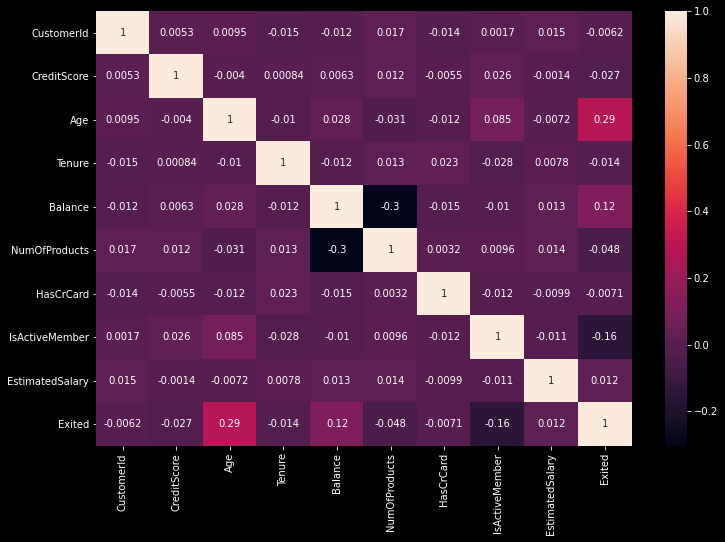

In [125]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

Features doesn't show much correlation with the target variables. IsActiveMember shows strong negative correlation with Exited. We will convert the categorical variables into integer variables to make more features.

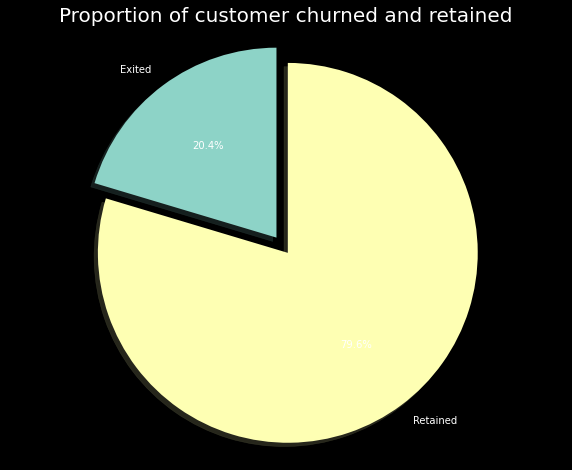

In [126]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

In [127]:
for var in df:
    if var != 'Exited':
        if len(list(df[var].unique())) <= 11:
            print(pd.DataFrame({'Mean_Exited': df.groupby(var)['Exited'].mean()}), end = "\n\n\n")

           Mean_Exited
Geography             
France            0.16
Germany           0.32
Spain             0.17


        Mean_Exited
Gender             
Female         0.25
Male           0.16


        Mean_Exited
Tenure             
0              0.23
1              0.22
2              0.19
3              0.21
4              0.21
5              0.21
6              0.20
7              0.17
8              0.19
9              0.22
10             0.21


               Mean_Exited
NumOfProducts             
1                     0.28
2                     0.08
3                     0.83
4                     1.00


           Mean_Exited
HasCrCard             
0                 0.21
1                 0.20


                Mean_Exited
IsActiveMember             
0                      0.27
1                      0.14




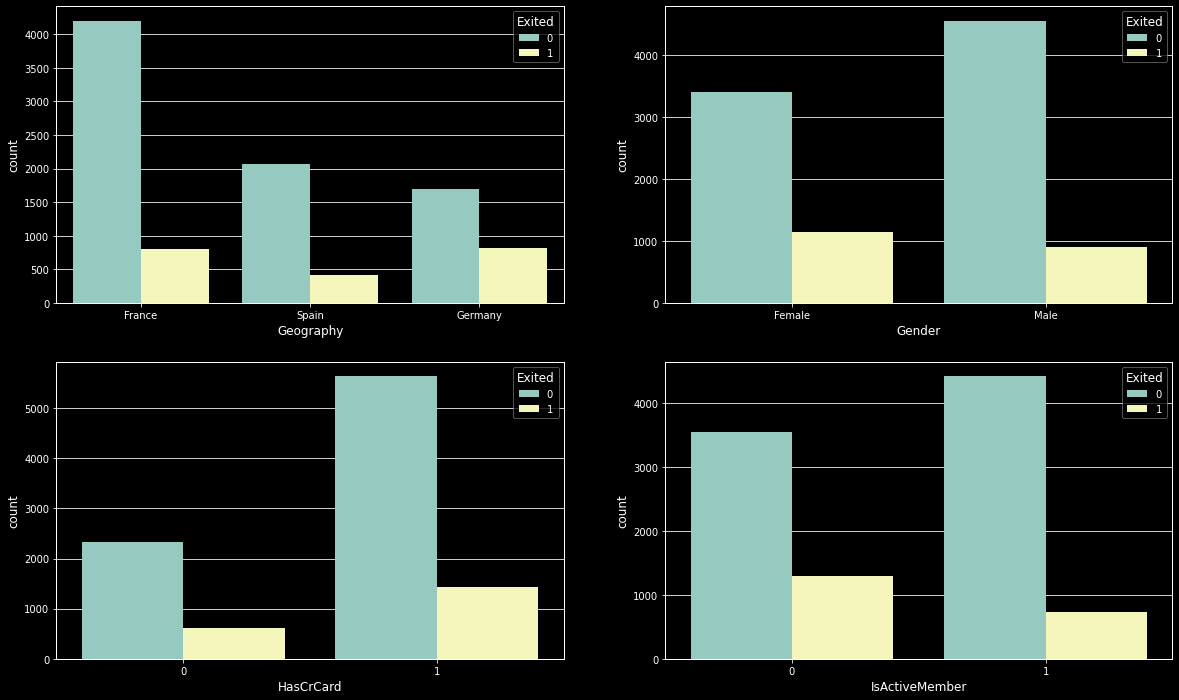

In [128]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

**We note the following:**

- Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients. Also the churning percentage in Germany is much more as compared to France and Spain.

- The proportion of female customers churning is also greater than that of male customers

- Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.

- Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive members is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

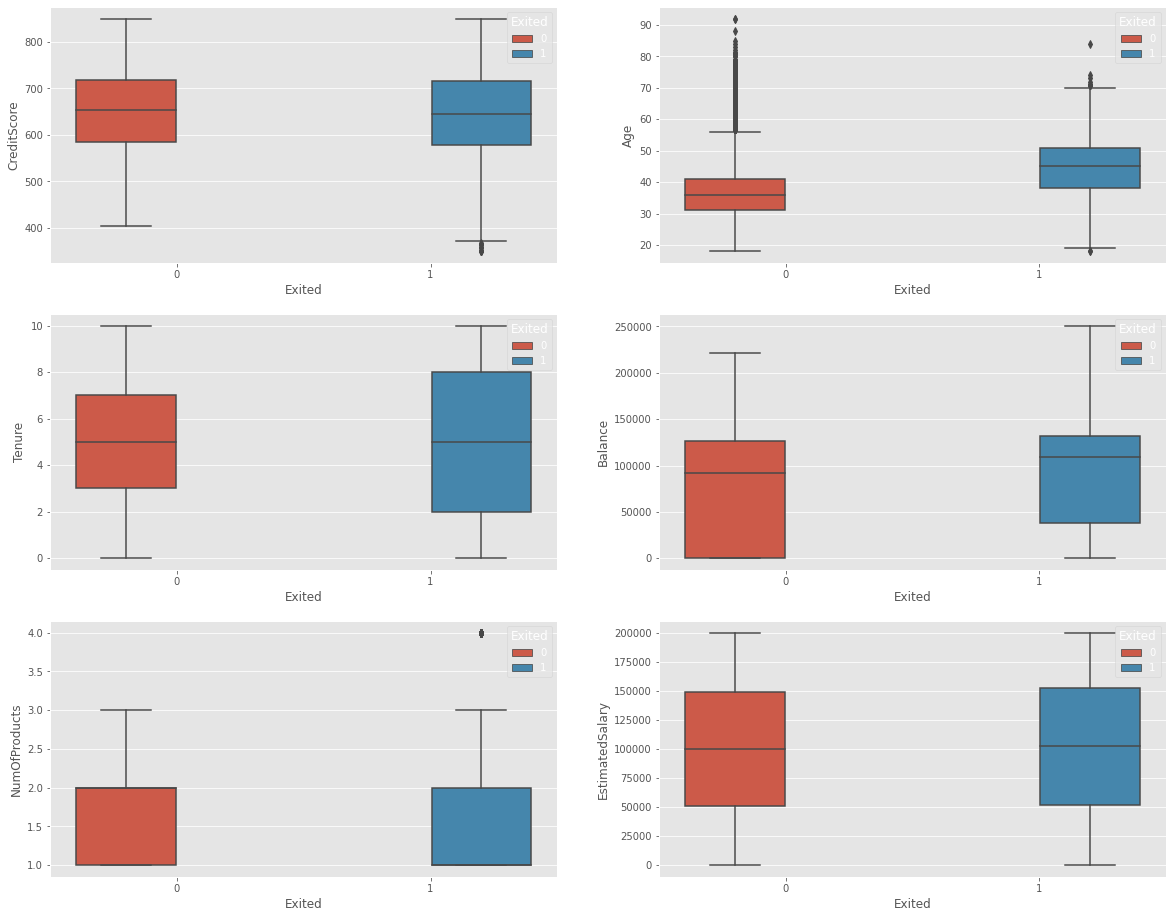

In [133]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 16))
plt.style.use('ggplot')

sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

**We note the following:**

- There is no significant difference in the credit score distribution between retained and churned customers.
    
- The older customers are churning more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
    
- With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
    
- Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
    
- Neither the product nor the salary has a significant effect on the likelihood to churn.


### 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

(-1.0, 5.0)

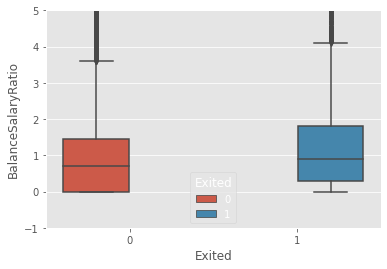

In [135]:
#df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
plt.style.use('ggplot')
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 5)

we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

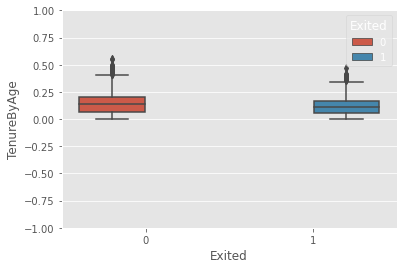

In [136]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 1)
plt.show()

In [137]:
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)

In [138]:
# France=0  Spain=1  Germany=2
df['Geography'].replace(to_replace=['France', 'Spain', 'Germany'],value=[0, 1, 2], inplace=True)

In [139]:
# Female=0  Male=1
df['Gender'].replace(to_replace=['Female', 'Male'],value=[0, 1], inplace=True)

In [140]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,15634602,619,0,0,42,2,0.00,1,1,1,"101,348.88",1,0.00,0.05,14.74
1,15647311,608,1,0,41,1,"83,807.86",1,0,1,"112,542.58",0,0.74,0.02,14.83
2,15619304,502,0,0,42,8,"159,660.80",3,1,0,"113,931.57",1,1.40,0.19,11.95
3,15701354,699,0,0,39,1,0.00,2,0,0,"93,826.63",0,0.00,0.03,17.92
4,15737888,850,1,0,43,2,"125,510.82",1,1,1,"79,084.10",0,1.59,0.05,19.77


In [142]:
#downcast datatypes to save memory
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerId           10000 non-null  int32  
 1   CreditScore          10000 non-null  int16  
 2   Geography            10000 non-null  int8   
 3   Gender               10000 non-null  int8   
 4   Age                  10000 non-null  int8   
 5   Tenure               10000 non-null  int8   
 6   Balance              10000 non-null  float32
 7   NumOfProducts        10000 non-null  int8   
 8   HasCrCard            10000 non-null  int8   
 9   IsActiveMember       10000 non-null  int8   
 10  EstimatedSalary      10000 non-null  float32
 11  Exited               10000 non-null  int8   
 12  BalanceSalaryRatio   10000 non-null  float32
 13  TenureByAge          10000 non-null  float32
 14  CreditScoreGivenAge  10000 non-null  float32
dtypes: float32(5), int16(1), int32(1), in

### 5. Splitting the data as train and validation data

The given data is splitted into train and validation sets to test the accuracy of training with the untrained 20% of the sample.

In [145]:
xs = df.drop(["Exited"], axis=1)
target = df["Exited"]
x_train, x_val, y_train, y_val = train_test_split(xs, target, test_size = 0.20, random_state = 0)

val_ids = x_val['CustomerId']
train_ids=x_train['CustomerId']

x_train = x_train.drop(['CustomerId'], axis=1)
x_val= x_val.drop(['CustomerId'], axis=1)

df_train=df[df['CustomerId'].isin(train_ids)]
df_val=df[df['CustomerId'].isin(val_ids)]

In [146]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 7389 to 2732
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          8000 non-null   int16  
 1   Geography            8000 non-null   int8   
 2   Gender               8000 non-null   int8   
 3   Age                  8000 non-null   int8   
 4   Tenure               8000 non-null   int8   
 5   Balance              8000 non-null   float32
 6   NumOfProducts        8000 non-null   int8   
 7   HasCrCard            8000 non-null   int8   
 8   IsActiveMember       8000 non-null   int8   
 9   EstimatedSalary      8000 non-null   float32
 10  BalanceSalaryRatio   8000 non-null   float32
 11  TenureByAge          8000 non-null   float32
 12  CreditScoreGivenAge  8000 non-null   float32
dtypes: float32(5), int16(1), int8(7)
memory usage: 289.1 KB


### 6. Modeling, Evaluation and Model Tuning

**Validation Set Accuracy for the default models**

In [160]:
r=2030
models = [LogisticRegression(random_state=r),GaussianNB(), KNeighborsClassifier(),BaggingClassifier(random_state=r),DecisionTreeClassifier(random_state=r),
          RandomForestClassifier(random_state=r), GradientBoostingClassifier(random_state=r),
          XGBClassifier(random_state=r), MLPClassifier(random_state=r),
          CatBoostClassifier(random_state=r,verbose = False)]
names = ["LogisticRegression","GaussianNB","KNN","Bagging",
             "DecisionTree","Random_Forest","GBM","XGBoost","Art.Neural_Network","CatBoost"]

In [152]:
print('Default model validation accuracies for the train data:', end = "\n\n")
for name, model in zip(names, models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val) 
    print(name,':',"%.3f" % accuracy_score(y_pred, y_val))

Default model validation accuracies for the train data:

LogisticRegression : 0.793
GaussianNB : 0.795
KNN : 0.764
SVC : 0.797
Bagging : 0.857
DecisionTree : 0.794
Random_Forest : 0.868
GBM : 0.867
[12:31:05] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost : 0.853
Art.Neural_Network : 0.796
CatBoost : 0.860


**Cross validation accuracy and std of the default models for all the train data**

In [153]:
predictors=pd.concat([x_train,x_val])

In [154]:
results = []
print('10 fold Cross validation accuracy and std of the default models for the train data:', end = "\n\n")
for name, model in zip(names, models):
    kfold = KFold(n_splits=10, random_state=1001)
    cv_results = cross_val_score(model, predictors, target, cv = kfold, scoring = "accuracy")
    results.append(cv_results)
    print("{}: {} ({})".format(name, "%.3f" % cv_results.mean() ,"%.3f" %  cv_results.std()))

10 fold Cross validation accuracy and std of the default models for the train data:

LogisticRegression: 0.796 (0.010)
GaussianNB: 0.271 (0.175)
KNN: 0.760 (0.012)
SVC: 0.796 (0.010)
Bagging: 0.779 (0.013)
DecisionTree: 0.661 (0.013)
Random_Forest: 0.794 (0.010)
GBM: 0.795 (0.010)
[12:33:16] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:33:17] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:33:18] WARNING: /Users/adamyanayyar/xgboost/py

**Model tuning using crossvalidation**

In [162]:
# Possible hyper parameters
logreg_params= {"C":np.logspace(-1, 1, 10),
                    "penalty": ["l1","l2"], "solver":['lbfgs', 'liblinear', 'sag', 'saga'], "max_iter":[1000]}

NB_params = {'var_smoothing': np.logspace(0,-9, num=100)}
knn_params= {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
svc_params= {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1, 5, 10 ,50 ,100],
                 "C": [1,10,50,100,200,300,1000]}
bag_params={"n_estimators":[50,120,300]}
dtree_params = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}
rf_params = {"max_features": ["log2","auto","sqrt"],
                "min_samples_split":[2,3,5],
                "min_samples_leaf":[1,3,5],
                "bootstrap":[True,False],
                "n_estimators":[50,100,150],
                "criterion":["gini","entropy"]}
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

xgb_params ={
        'n_estimators': [50, 100, 200],
        'subsample': [ 0.6, 0.8, 1.0],
        'max_depth': [1,2,3,4],
        'learning_rate': [0.1,0.2, 0.3, 0.4, 0.5],
        "min_samples_split": [1,2,4,6]}

mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],"max_iter":[1000]}
catb_params =  {'depth':[2, 3, 4],
              'loss_function': ['Logloss', 'CrossEntropy'],
              'l2_leaf_reg':np.arange(2,31)}
classifier_params = [logreg_params,NB_params,knn_params,bag_params,dtree_params,rf_params,
                     gbm_params, xgb_params,mlpc_params,catb_params] 

In [163]:
# Tuning by Cross Validation  
cv_result = {}
best_estimators = {}
for name, model,classifier_param in zip(names, models,classifier_params):
    with timer(">Model tuning"):
        clf = GridSearchCV(model, param_grid=classifier_param, cv =6, scoring = "accuracy", n_jobs = -1,verbose = False)
        clf.fit(x_train,y_train)
        cv_result[name]=clf.best_score_
        best_estimators[name]=clf.best_estimator_
        print(name,'cross validation accuracy : %.3f'%cv_result[name])

LogisticRegression cross validation accuracy : 0.816
>Model tuning done in 120s
GaussianNB cross validation accuracy : 0.796
>Model tuning done in 2s
KNN cross validation accuracy : 0.793
>Model tuning done in 5s
Bagging cross validation accuracy : 0.854
>Model tuning done in 46s
DecisionTree cross validation accuracy : 0.857
>Model tuning done in 18s
Random_Forest cross validation accuracy : 0.864
>Model tuning done in 1141s
GBM cross validation accuracy : 0.865
>Model tuning done in 1898s
[16:50:11] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:11] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10

In [164]:
accuracies={}
print('Validation accuracies of the tuned models for the train data:', end = "\n\n")
for name, model_tuned in zip(best_estimators.keys(),best_estimators.values()):
    y_pred =  model_tuned.fit(x_train,y_train).predict(x_val)
    accuracy=accuracy_score(y_pred, y_val)
    print(name,':', "%.3f" %accuracy)
    accuracies[name]=accuracy

Validation accuracies of the tuned models for the train data:

LogisticRegression : 0.821
GaussianNB : 0.797
KNN : 0.794
Bagging : 0.862
DecisionTree : 0.865
Random_Forest : 0.868
GBM : 0.864
[22:52:53] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:52:53] WARNING: /Users/adamyanayyar/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost : 0.865
Art.Neural_Network : 0.797
CatBoost :

**Ensemble best 3 models with most accuracies**

In [165]:
n=3
accu=sorted(accuracies, reverse=True, key= lambda k:accuracies[k])[:n]
firstn=[[k,v] for k,v in best_estimators.items() if k in accu]

In [166]:
# Ensembling First n Score

votingC = VotingClassifier(estimators = firstn, voting = "soft", n_jobs = -1)
votingC = votingC.fit(x_train, y_train)
print(accuracy_score(votingC.predict(x_val),y_val))


0.87


### Conclusion

Ensemble model gives us more confidence regarding our output and hence we are able to create a model with around 87% accuracy which is an improvement over our base accuracy of 80%. Now depending upon the problem statement we could furthur find the model with better precision or recall.